In [1]:
import bz2
import lzma
import pickle
import json
import os.path
import sys
import time

from imageio import imread
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})

import numba as nb
nb_u1 = nb.types.uint8
nb_u2 = nb.types.uint16

from bson.binary import Binary
import pymongo

sys.path.append(r'C:\Users\hornu\OneDrive\Documents\repos\flags\scripts\image-scripts')
from image_scaler_cleaner import ImageScalerCleaner

A concise document based database is designed and created for the flags of the countries across the globe in which textual, numeric and image data are stored.


## Motivation

We have embarked on a journey to learn more about flags and what they represent. In the previous post we preprocessed the images which store the graphical representations. In this one we proceed one step forward in the data analysis pipeline.

## Database design

### Current data structure

The database, `flags` as it stands now:

In [2]:
mg_client = pymongo.MongoClient("mongodb://localhost:27017/")
print(mg_client.list_database_names())

['admin', 'config', 'flags', 'local']


consists of a single collection, `raw_countries`:

In [3]:
db_flag = mg_client["flags"]
print(db_flag.list_collection_names())

['countries', 'flags', 'raw_countries']


in which each document lists the attributes of a particular country:

In [4]:
cl_raw_countries = db_flag["raw_countries"]
cl_raw_countries.find_one({})

{'_id': ObjectId('5cb05096351ab07c5454114d'),
 'adapted': 2004,
 'path': 'C:\\Users\\hornu\\OneDrive\\Documents\\repos\\flags\\data\\clean-data\\images\\afghanistan.png',
 'code': 'AF',
 'religion': 'ISLAM',
 'continent': 'ASIA',
 'founded': 9999,
 'independent': 1823,
 'neighbours': ['CN', 'IR', 'PK', 'TJ', 'TM', 'UZ'],
 'name': 'AFGHANISTAN'}

The fields are either pertaining to the country itself:

* `name` : name of the country
* `code` : two-letter iso code of the country
* `founded` : year in which the country or its ancestor was founded. 9999 stands for missing datum.
* `independent` : year in which the country became independent
* `religion` : predominant religion in the country
* `continent` : continent on which the major landmass of the country situated
* `neighbours` : the two letter iso codes of its neighbours

or to its flag:
* `adapted` : year in which the current flag was introduced
* `path` : path to the `png` image of the flag in local store

### Design goals

We wish to store these pieces of information in a more orderly fashion. The fields relevant to the country should be contained in a document separated from those relevant to the flag itself. Two collections will thus be created: 

* `countries` and
* `flags`

#### Country document

A country document will have three main fields
* `_id` : unique id
* `code` : two-letter iso code of the country
* `flag` : id of the associated flag document
* `data` : all other fields
    * `name` : name of the country
    * `founded` :  ...
    * `independent` : ...
    * `adapted` : ...
    * `continent` : ...
    * `religion` : ...
    * `neighbours` : ...
    
    
The country codes of the `neighbours` list will be replaced by the list of the `_id`-s of the respective country documents. This implies the collection must be built in two passes.

#### Flag document

The flags are stored in a different collection. The schema of a document is the following:

* `_id` : unique id
* `code` : two letter country code
* `data` : information on the flag
    * `colours` : a dictionary in which the flag's constituent colours are listed along with their weights
    * `dimensions` : a dictionary of height and width
    * `canvas` : the flag itself
 
We wish to keep this document as sleek as possible. Therefore only the canvas, some precomputed statitics and the human readable country codes are included in it.

## Implementation

We set out to implement all the transformations that are required to create the new database.

### Flags

The main issue is to find an efficient format for storing the canvas of the flag. We went at [great length](https://bhornung.github.io/python/2019/04/09/flags-1.html) to rid the flag of spurious colours, therefore any lossy compression is out of question. 

#### Copressing the flag

The cleaned image is a 3D `uint8` numpy array.  Let us assume an average flag has $500 \cot 1000$ pixels. Each pixel consists of three meaningful channels (R, G, B). It is then represented in the memory as an array of of size $500 \cdot 1000 \cdot 3 = 1.5 \cdot 10^{6}$ This corresponds to 1.5MBs per image. We wish to make our objects as small as possible so that they travel through the network and memory quickly.

There are multiple paths to achieve this:
* `numpy` array $\rightarrow$ pickled object $\rightarrow$ `lzma`-ed object $\rightarrow$ Binary field in mongodb
* `numpy` array $\rightarrow$ compressed/modified `numpy` array $\rightarrow$ pickled object $\rightarrow$ Binary field in `mongodb`
* `numpy` array $\rightarrow$ compressed/modified `numpy` array $\rightarrow$ pickled object $\rightarrow$ `lzma`-ed object $\rightarrow$ Binary field in `mongodb`

In the first route, the pickled array is compressed. These images compress really well, for there are many similar byte sequences corresponding to identical colours. The drawback is that the image has to be manipulated by `lzma` which can be slow.

Following the second path, one modifies the numpy array to an other one of considerably smaller size whilst retaining all the spatial information. This array is then pickled. In this case the unpickled object can be used by numpy straightaway. The drawback that the custom compressor/decompressor has to be used, and the user has to be warned accordingly.

The third one might be a slow overkill. 

A minimalistic compressor--decompressor pair is implemented below. `compress_image2` looks for horizontal sequences of indetical colours. (Notwithstanding there is much room for improvement, we choose not delve too deep into optimising these utilities at this stage.

In [5]:
@nb.jit(nopython = True)
def compress_image2(X):
    """
    Creates a coordinate sparse array representation of an RGB image.
    Parameters:
        X (np.ndarray[height, width, 3] of uint8) : RGB image.
        
    Returns:
        compressed (np.ndarray[n_regions, 7]) : compressed image, where
            row[0:4] : row start, column start, row end, column end
            row[4:] : R, G, B codes of the region of constant colour. 
    """
    
    ir, jr, _ = X.shape
    coo = []
    
    r_s, c_s = 0, 0
    c_old = X[0, 0]
    
    for i in range(ir):
        
        for j in range(0, jr):
            
            # append end of color region and colour
            if X[i, j, 0] != c_old[0] or \
               X[i, j, 1] != c_old[1] or \
               X[i, j, 2] != c_old[2]:
                
                if j == 0:
                    coo.append([r_s, c_s, i - 1, jr, c_old[0], c_old[1], c_old[2]])
                    
                else:
                    coo.append([r_s, c_s, i, j, c_old[0], c_old[1], c_old[2]])
                    
                c_old = X[i, j]
                r_s, c_s = i, j
        
    coo.append([r_s, c_s, ir - 1, jr, c_old[0], c_old[1], c_old[2]])
    
    compressed = np.array(coo, dtype = np.uint16)
    
    return compressed

The decompressor, `decompress_image2` fills subsequent regions with colours.

In [6]:
@nb.jit(nopython = True)
def decompress_image2(X):
    """
    Creates a coordinate sparse array representation of an RGB image.
    
    Parameters:
        X (np.ndarray[n_regions, 7]) : compressed image, where
            row[0:4] : row start, column start, row end, column end
            row[4:] : R, G, B codes of the region of constant colour.
    Returns:
        decompressed (np.ndarray[height, width, 3] of uint8) : RGB image.
    """
    
    h = np.int64(X[-1, 2] + 1)
    v = np.int64(X[-1, 3])
    
    decompressed = np.zeros((h, v, 3), dtype = np.uint8)
    
    for k in range(X.shape[0]):
        
        r_s = X[k,0]
        c_s = X[k,1]
        r_e = X[k,2]
        c_e = X[k,3]
        
        if r_s == r_e:
            decompressed[r_s, c_s : c_e] = X[k, 4:]
            
        elif r_s + 1 == r_e:
            decompressed[r_s, c_s :] = X[k, 4:]
            decompressed[r_e, : c_e] = X[k, 4:]
            
        else:
            
            decompressed[r_s, c_s :] = X[k, 4:]
            decompressed[r_s + 1 : r_e, :] = X[k, 4:]
            decompressed[r_e, : c_e] = X[k, 4:]

    return decompressed

In [7]:
# TO SKIP -- boring

# choose specified number of random images
path_to_image_dir = r'C:\Users\hornu\OneDrive\Documents\repos\flags\data\clean-data\images'
paths = np.array([os.path.join(path_to_image_dir, x) for x in os.listdir(path_to_image_dir)])

n_sel = 50
idcs_sel = np.random.choice(len(paths), n_sel, replace = False)

images = [ImageScalerCleaner().clean(imread(paths[idx])) for idx in idcs_sel]

In [8]:
# TO SKIP -- boring

ratios_1 = np.zeros(n_sel, dtype = np.float32)
times_1 = np.zeros(n_sel, dtype = np.float32)

for idx, image in enumerate(images):
    
    # times
    t_start = time.perf_counter()
    compressed_dump = lzma.compress(pickle.dumps(image))
    recon = pickle.loads(lzma.decompress(compressed_dump))
    t_end = time.perf_counter()
    
    times_1[idx] = t_end - t_start
    
    # compression ratio
    ratios_1[idx] = len(compressed_dump) / (image.size * 2) 

In [9]:
# TO SKIP -- boring

ratios_2 = np.zeros(n_sel, dtype = np.float32)
times_2 = np.zeros(n_sel, dtype = np.float32)

for idx, image in enumerate(images):
    
    # times
    t_start = time.perf_counter()
    compressed_dump = pickle.dumps(compress_image2(image))
    recon = decompress_image2(pickle.loads(compressed_dump))
    t_end = time.perf_counter()
    
    times_2[idx] = t_end - t_start
    
    # compression ratio
    ratios_2[idx] = len(compressed_dump) / (image.size * 2) 

The compression ratios and execution times are compared on a randomly selected set of fifty images. The execution time includes 
* pickling
* compression
* extraction
* unpickling
for both routes.

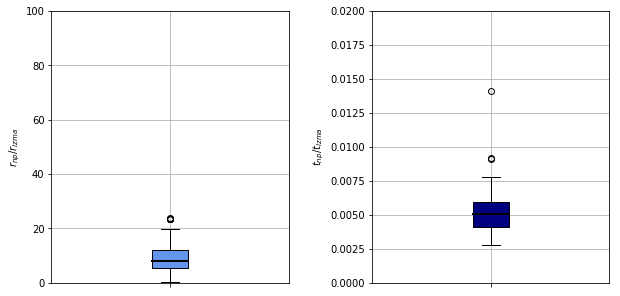

In [25]:
# TO SKIP -- plot setup

fig, axes = plt.subplots(1, 2, gridspec_kw = {"wspace" : 0.35})
fig.set_size_inches(10, 5)

axes[0].grid(True); axes[1].grid(True)
axes[0].set_ylim((0,100)); axes[1].set_ylim((0,0.02));
axes[0].set_ylabel(r'$r_{np} / r_{lzma}$'); axes[1].set_ylabel(r'$t_{np} / t_{lzma}$');

box_plot = axes[0].boxplot(ratios_2 /ratios_1, labels=[''], patch_artist=True, medianprops=dict(linewidth=2, color='black'))
box_plot['boxes'][0].set_facecolor('cornflowerblue')
        
box_plot = axes[1].boxplot(times_2 /times_1, labels=[''], patch_artist=True, medianprops=dict(linewidth=2, color='black'))
box_plot['boxes'][0].set_facecolor('navy')

plt.show()

The `lzma` achieves ten to fifteen times better compression ratio, for it has a global view of the bytes that encode the object. The compactness incurrs a high cost in time. It is hundred times slower than the full `numpy` cycle. The rough average timings are 100 ms and 1 ms per image _via_ the `lmza` and `numpy` paths, respectively.

As to which one to use, depends on the query time as a function the size of the compressed and pickled object.

#### Flag data structure

The following steps should be executed to obtain a json template of the "flag" document:

1. choose relavant fields from raw country documents
2. load image from local store
3. clean image 
4. compress and pickle canvas
5. generate other statistics fields
6. collate to a dictionary

Steps 1.--4. are done by the modestly interesting function `create_flag_object_dict` which is shown in its full g(l)ory below. The `ImageScalerCleaner` removes spurious colours due to finite resolution from a flag. Its construction and characteristics were discussed in [this blog post](https://bhornung.github.io/python/2019/04/09/flags-1.html) the source code can be located in [this folder](https://github.com/bhornung/bhornung.github.io/blob/master/assets/flags-1/scripts/image_scripts/image_scaler_cleaner.py).

In [11]:
def create_flag_document_dict(path, code):
    """
    Reads, cleans compresses a flag and collates with other relevant attributes.
    Parameters:
        path (str) : local path to the image
        code (str) : two letter country code
    
    Returns:
        document_dict ({:}) : dictionary of flag attributes.
    """
    
    # create flag bytestring
    image = imread(path)
    cleaner = ImageScalerCleaner()
    image_cleaned = cleaner.clean(image)
    image_bytes = Binary(pickle.dumps(compress_image2(image_cleaned)))
    
    # get dimensions
    height, width = image.shape[:2]
    
    # get colour histogram
    stringify = lambda x: "-".join([str(y) for y in x])
    colours = {stringify(colour) : weight 
                       for colour, weight in zip(cleaner.histo.colours, cleaner.histo.counts)}
    
    data = {
             "canvas" : image_bytes,
             "dimensions" : {"height" : height, "width" : width},
             "colours" : colours
            }
        
    # collate to all fields
    document_dict = {
                    "code" : code,
                    "data" : data
                  }
    
    return document_dict

### Country document



The fields of the country document are populated from the query result. The `flag` field is omitted, for it will be added once the ids of the flag documents are known.

In [12]:
def create_country_document_dict(fields):
    """
    Creates a dictionary representing a flag document
    Parameters:
        fields ({:}) : raw country attributes as a dictionary
        
    Returns:
        document_dict ({:}) : dictionary containing the relevant attributes of a certain country
    """
    
    # copy accross relevant fields
    data_field_names = ('name', 'continent', 'founded', 'independent', 'neighbours', 'religion')
    data = {field_name : fields[field_name] for field_name in data_field_names}
    
    document_dict = {
                    "code" : fields['code'],
                    'data' : data,
                    }
    
    return document_dict

## Creating the collections

### Flags

All flag dictionaries are created in a single pass over the returned elements from querying the `raw_countries` collection.

In [13]:
cl_raw_countries = db_flag["raw_countries"]
flag_dicts = [create_flag_document_dict(x['path'], x['code']) for x in cl_raw_countries.find({})]

From these items the `flags` collection is created. If there is an earlier version it will be dropped.

In [14]:
if 'flags' in db_flag.list_collection_names():
    db_flag.drop_collection('flags')
    
cl_flag = db_flag.create_collection('flags')
cl_flag.insert_many(flag_dicts)

As a test, we retrieve the flag of Algeria. As expected, there is only one matching document.(Please note, the bytestring is truncated.)

In [15]:
flags = cl_flag.find({'code' : 'DZ'})
for flag in flags:
    print('code :', flag['code'])
    print('data : colours :', flag['data']['colours'])
    print('data : dimensions :', flag['data']['dimensions'])
    print('data : canvas : ', flag['data']['canvas'][:100])

code : DZ
data : colours : {'255-255-255': 0.4793593513320859, '0-98-51': 0.4606121357925688, '210-16-52': 0.060028512875345275}
data : dimensions : {'height': 387, 'width': 580}
data : canvas :  b'\x80\x03cnumpy.core.multiarray\n_reconstruct\nq\x00cnumpy\nndarray\nq\x01K\x00\x85q\x02C\x01bq\x03\x87q\x04Rq\x05(K\x01M\xa0\x05K\x07\x86q\x06cnumpy\ndtype\nq\x07X'


Next, we print all flags whose canvases contain pure red:

In [16]:
for flag in cl_flag.find({'data.colours.255-0-0' : {'$exists' : True} }, {'code' : 1}):
    print(flag)

{'_id': ObjectId('5cb06a2c351ab08028a97afb'), 'code': 'AU'}
{'_id': ObjectId('5cb06a2c351ab08028a97b11'), 'code': 'CA'}
{'_id': ObjectId('5cb06a2c351ab08028a97b1b'), 'code': 'HR'}
{'_id': ObjectId('5cb06a2c351ab08028a97b30'), 'code': 'GE'}
{'_id': ObjectId('5cb06a2c351ab08028a97b7b'), 'code': 'PT'}
{'_id': ObjectId('5cb06a2c351ab08028a97b9a'), 'code': 'CH'}
{'_id': ObjectId('5cb06a2c351ab08028a97baa'), 'code': 'AE'}


### Countries

A list of dictionaries are created from the query on the raw countries:

In [17]:
country_dicts = [create_country_document_dict(x) for x in cl_raw_countries.find({})]

The collection of countries is built in three passes:
1. The prepared dictionries are inserted
2. The `flag` fields are populated with the ids of the related flags
3. The two letter codes are replaced by the country ids

In [18]:
if 'countries' in db_flag.list_collection_names():
    db_flag.drop_collection('countries')

cl_countries = db_flag.create_collection('countries')
cl_countries.insert_many(country_dicts)

Let us display the record of South Africa:

In [19]:
next(cl_countries.find({'code' : 'ZA'}))

{'_id': ObjectId('5cb06a2c351ab08028a97c55'),
 'code': 'ZA',
 'data': {'name': 'SOUTH AFRICA',
  'continent': 'AFRICA',
  'founded': 1910,
  'independent': 1910,
  'neighbours': ['BW', 'LS', 'MZ', 'NA', 'SZ', 'ZW'],
  'religion': 'CHR'}}

We then search for all countries that became independent between 1989 an 1993. We are expecting to see states from the reorganised Eastern Block, which we do.

In [20]:
for country in cl_countries.find({'data.independent' : {'$gt' : 1988, '$lt' : 1994}}, {'code' : 1}):
    print(country)

{'_id': ObjectId('5cb06a2c351ab08028a97bbe'), 'code': 'AM'}
{'_id': ObjectId('5cb06a2c351ab08028a97bc1'), 'code': 'AZ'}
{'_id': ObjectId('5cb06a2c351ab08028a97bc6'), 'code': 'BY'}
{'_id': ObjectId('5cb06a2c351ab08028a97bcc'), 'code': 'BA'}
{'_id': ObjectId('5cb06a2c351ab08028a97bdf'), 'code': 'HR'}
{'_id': ObjectId('5cb06a2c351ab08028a97be2'), 'code': 'CZ'}
{'_id': ObjectId('5cb06a2c351ab08028a97bec'), 'code': 'ER'}
{'_id': ObjectId('5cb06a2c351ab08028a97bed'), 'code': 'EE'}
{'_id': ObjectId('5cb06a2c351ab08028a97bf4'), 'code': 'GE'}
{'_id': ObjectId('5cb06a2c351ab08028a97bf5'), 'code': 'DE'}
{'_id': ObjectId('5cb06a2c351ab08028a97c0b'), 'code': 'KZ'}
{'_id': ObjectId('5cb06a2c351ab08028a97c0f'), 'code': 'KG'}
{'_id': ObjectId('5cb06a2c351ab08028a97c11'), 'code': 'LV'}
{'_id': ObjectId('5cb06a2c351ab08028a97c17'), 'code': 'LT'}
{'_id': ObjectId('5cb06a2c351ab08028a97c19'), 'code': 'MK'}
{'_id': ObjectId('5cb06a2c351ab08028a97c25'), 'code': 'MD'}
{'_id': ObjectId('5cb06a2c351ab08028a97c

In the next step the ids of the associated flag documents are inserted. Since the two letter code is included in each flag document they can easily be found.

In [21]:
for flag in db_flag.flags.find():
    db_flag.countries.update_one(
            {'code': flag['code'] },
            {'$set': {'flag': flag['_id']}}
    )

The each document now contains the id of the associated flag:

In [22]:
db_flag.countries.find_one({'code' : 'ZA'})

{'_id': ObjectId('5cb06a2c351ab08028a97c55'),
 'code': 'ZA',
 'data': {'name': 'SOUTH AFRICA',
  'continent': 'AFRICA',
  'founded': 1910,
  'independent': 1910,
  'neighbours': ['BW', 'LS', 'MZ', 'NA', 'SZ', 'ZW'],
  'religion': 'CHR'},
 'flag': ObjectId('5cb06a2c351ab08028a97b91')}

Finally, the two letter codes in the neighbour list are replaced by the id-s of the countries they represent:

In [23]:
for country in db_flag.countries.find():
    
    # find ids of neighbouring countries
    ids = [db_flag.countries.find_one({'code' : code})['_id'] for code in country['data']['neighbours']]
     
    # update country
    cid = country['_id']
    db_flag.countries.update_one(
            {'_id' : cid}, 
            {'$set' : {'data.neighbours' : ids}}
    )

The updated field therefore lists the object ids of the neighbouring countries

In [24]:
db_flag.countries.find_one({'code' : 'FR'})

{'_id': ObjectId('5cb06a2c351ab08028a97bf1'),
 'code': 'FR',
 'data': {'name': 'FRANCE',
  'continent': 'EUROPE',
  'founded': 9999,
  'independent': 1944,
  'neighbours': [ObjectId('5cb06a2c351ab08028a97c6f'),
   ObjectId('5cb06a2c351ab08028a97bba'),
   ObjectId('5cb06a2c351ab08028a97bc7'),
   ObjectId('5cb06a2c351ab08028a97bf5'),
   ObjectId('5cb06a2c351ab08028a97c07'),
   ObjectId('5cb06a2c351ab08028a97c18'),
   ObjectId('5cb06a2c351ab08028a97c26'),
   ObjectId('5cb06a2c351ab08028a97c58'),
   ObjectId('5cb06a2c351ab08028a97c5e')],
  'religion': 'CHR'},
 'flag': ObjectId('5cb06a2c351ab08028a97b2d')}

## Summary

A mongoDB database has been created in which attributes of countries and their flags are stored. The countries and their flags are stored in separate collection, therefore keeping the former's size small, and the latter one concise.